In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from hnea_genes import *

In [2]:
# Load all the data, including for genes with low confidence calls.
long_df = pd.read_csv('../data/Hnea/barseq/fit_logratios_all_long.csv')

# Load annotation data
annot_df = pd.read_csv('../data/Hnea/barseq/2017_11_03_miseq_barSeq1/genes', sep='\t', index_col=0)

# Can't plot pairwise data with biological duplicates, so we take the mean fitness per-gene first.
tmp = long_df.groupby(['locus_id', 'cond', 'ccm_gene', 'gene_tag']).mean().reset_index()
p = tmp.pivot('locus_id', 'cond')
mean_fitness_df = p['value'].copy()

# Put the tags back in there for later plotting.
mean_fitness_df['ccm_gene'] = p['ccm_gene']['ambient CO2']
mean_fitness_df['gene_tag'] = p['gene_tag']['ambient CO2']

mean_fitness_df.head()

cond,0.5% CO2,1.5% CO2,10% CO2,5% CO2,ambient CO2,ccm_gene,gene_tag
locus_id,,,,,,,
GFF1190,-0.080285,0.021461,-0.079133,-0.001788,0.049010,False,other
GFF1209,0.033399,0.198126,-0.086236,0.031059,-0.082330,False,other
GFF1357,-1.188559,-1.082507,-0.924616,-0.842707,-0.329688,False,other
GFF1439,0.173600,-0.154247,0.095518,-0.175644,-0.279369,False,other
GFF1496,-0.580384,0.029104,-0.227856,0.285289,0.255138,False,other


In [3]:
cond2co2 = {
    'ambient CO2':0.04,
    '0.5% CO2': 0.5,
    '1.5% CO2': 1.5,
    '5% CO2': 5,
    '10% CO2': 10
}
co2vals = [cond2co2.get(c, np.NaN) for c in long_df.cond]
long_df['co2_numeric'] = co2vals
long_df.head()

,locus_id,variable,value,gene_tag,gene_name,cond,rep,ccm_gene,co2_numeric
0,GFF1190,5% CO2,-0.000402,other,NaN,5% CO2,0,False,5.0
1,GFF1209,5% CO2,0.222629,other,NaN,5% CO2,0,False,5.0
2,GFF1357,5% CO2,-0.612701,other,NaN,5% CO2,0,False,5.0
3,GFF1439,5% CO2,-0.277288,other,NaN,5% CO2,0,False,5.0
4,GFF1496,5% CO2,0.676934,other,NaN,5% CO2,0,False,5.0


In [4]:
cols = 'value,co2_numeric'.split(',')
corrs = long_df.groupby('locus_id')[cols].corr()
corrs_series = corrs.xs('value', level=1)['co2_numeric']

In [5]:
# Move the correlations into the mean fitness DF
mean_fitness_df['corr_CO2'] = corrs_series

# Drop the genes with data missing
corr_df = mean_fitness_df.dropna()

# Merge in the annotations
corr_df = corr_df.merge(
    annot_df, left_index=True, right_index=True).sort_values('corr_CO2', ascending=False)

co2_cols = list(cond2co2.keys())
corr_df['mean_effect_size'] = np.abs(corr_df[co2_cols].mean(axis=1))

corr_df.head()

,0.5% CO2,1.5% CO2,10% CO2,5% CO2,ambient CO2,ccm_gene,gene_tag,corr_CO2,sysName,type,scaffoldId,begin,end,strand,name,desc,GC,nTA,mean_effect_size
HNEAP_RS02625,0.032783,0.000226,0.154012,0.097345,0.014121,False,other,0.873332,HNEAP_RS02625,1,NC_013422.1,561069,561890,+,NaN,3'(2') 5'-bisphosphate nucleotidase,0.5973,15,0.059698
HNEAP_RS05490,-5.018394,-2.798292,0.214332,0.012751,-5.650154,True,regulation,0.862229,HNEAP_RS05490,1,NC_013422.1,1179635,1180537,+,NaN,LysR family transcriptional regulator,0.5227,31,2.647951
HNEAP_RS04660,-5.003984,-3.034751,-0.030204,-0.056483,-5.338974,True,carboxysomal rubisco,0.860981,HNEAP_RS04660,1,NC_013422.1,989858,991279,-,NaN,ribulose bisphosphate carboxylase large chain,0.5316,40,2.692879
HNEAP_RS04610,-0.965045,-0.984399,-0.047963,-0.105952,-0.734319,True,regulation,0.847194,HNEAP_RS04610,1,NC_013422.1,982347,983027,-,NaN,ParA family protein,0.5169,18,0.567535
HNEAP_RS04575,-0.560974,-0.429182,-0.113678,-0.121131,-0.758189,True,chaperone,0.829891,HNEAP_RS04575,1,NC_013422.1,972739,973542,-,NaN,CbbQ/NirQ/NorQ/GpvN family protein,0.5050,19,0.396631


In [6]:
# CCM genes should have large effect sizes in ambient and be correlated with pCO2 
mask = np.logical_and(corr_df['corr_CO2'] > 0.4, corr_df['ambient CO2'] < -0.3)
masked_corr_df = corr_df[mask]

# CCM genes should have large effect sizes correlated with pCO2
cols2show = 'desc,mean_effect_size,corr_CO2,mean_effect_size,ccm_gene,gene_tag'.split(',')
masked_corr_df.sort_values('corr_CO2', ascending=False)[cols2show].round(3).head(30)

,desc,mean_effect_size,corr_CO2,mean_effect_size,ccm_gene,gene_tag
HNEAP_RS05490,LysR family transcriptional regulator,2.648,0.862,2.648,True,regulation
HNEAP_RS04660,ribulose bisphosphate carboxylase large chain,2.693,0.861,2.693,True,carboxysomal rubisco
HNEAP_RS04610,ParA family protein,0.568,0.847,0.568,True,regulation
HNEAP_RS04575,CbbQ/NirQ/NorQ/GpvN family protein,0.397,0.830,0.397,True,chaperone
HNEAP_RS04655,ribulose bisphosphate carboxylase small subunit,2.794,0.802,2.794,True,carboxysomal rubisco
HNEAP_RS04640,carboxysome peptide A,2.654,0.765,2.654,True,carboxysome
HNEAP_RS11635,ParA family protein,1.427,0.757,1.427,False,other
HNEAP_RS04630,major carboxysome shell protein 1C,2.671,0.751,2.671,True,carboxysome
HNEAP_RS04645,carboxysome shell carbonic anhydrase,1.904,0.751,1.904,True,CA
HNEAP_RS04650,hypothetical protein,2.476,0.745,2.476,True,carboxysome


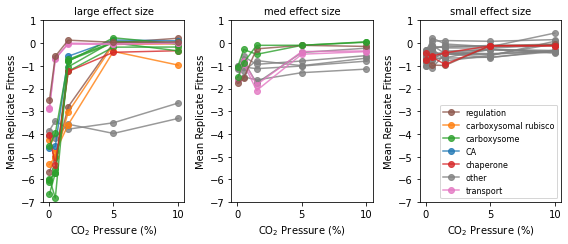

In [7]:
fig, axs = plt.subplots(ncols=3, figsize=(8,3.5))

pal = sns.color_palette(n_colors=masked_corr_df.shape[0])
cols = ['ambient CO2', '0.5% CO2', '1.5% CO2', '5% CO2', '10% CO2' ]
co2_conc_pct = np.array([0.04, 0.5, 1.5, 5, 10])

large_effect = masked_corr_df[masked_corr_df['ambient CO2'] < -2]
mask = np.logical_and(masked_corr_df['ambient CO2'] < -1, 
                      masked_corr_df['ambient CO2'] >= -2)
med_effect = masked_corr_df[mask]
small_effect = masked_corr_df[masked_corr_df['ambient CO2'] > -1]
titles = 'large effect size,med effect size,small effect size'.split(',')

tag2color = dict((t, pal[i]) for i, t in enumerate(sorted(masked_corr_df.gene_tag.unique())))
tag2color['other'] = 'grey'
legend_labels = dict()
for i, (my_df, my_ax) in enumerate(zip([large_effect, med_effect, small_effect], axs)):
    plt.sca(my_ax)
    plt.xlabel('CO$_2$ Pressure (%)')
    plt.ylabel('Mean Replicate Fitness')
    plt.ylim(-7, 1)
    plt.title(titles[i], fontsize=10)
    for j, (idx, row) in enumerate(my_df.iterrows()):
        # Color by tag, put CCM genes on top
        c = tag2color[row.gene_tag]
        z = 1 if row.gene_tag == 'other' else 2
        plt.plot(co2_conc_pct, row[cols], color=c, label=row.gene_tag,
                 zorder=z, alpha=0.8, ls='-', marker='o')
    
    handles, labels = my_ax.get_legend_handles_labels()
    legend_labels.update(dict(zip(labels, handles)))

plt.legend(legend_labels.values(), legend_labels.keys(), loc=4, fontsize=8)

plt.tight_layout()
plt.savefig('../figures/fig2/fitness_corr_co2_all_genes.png', facecolor='w', dpi=600)
plt.show()

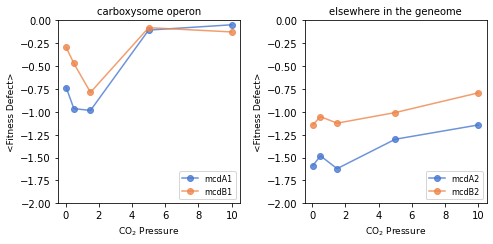

In [8]:
fig, axs = plt.subplots(ncols=2, figsize=(7,3.5))

gene_labels = {
    'HNEAP_RS04610': 'mcdA1',
    'HNEAP_RS04605': 'mcdB1',
    'HNEAP_RS11635': 'mcdA2',
    'HNEAP_RS11630': 'mcdB2',
}

pal = sns.color_palette('muted')
plots = ['HNEAP_RS04610,HNEAP_RS04605'.split(','), 'HNEAP_RS11635,HNEAP_RS11630'.split(',')]
titles = 'carboxysome operon,elsewhere in the geneome'.split(',')
for i, (p, ax) in enumerate(zip(plots, axs)):
    plt.sca(ax)
    for j, (idx, row) in enumerate(corr_df.loc[p].iterrows()):
        color = pal[j]
        plt.plot(co2_conc_pct, row[cols], color=color, label=gene_labels[idx],
                 alpha=0.8, ls='-', marker='o')
        plt.title(titles[i], fontsize=10)
        plt.legend(fontsize=8, loc=4)
        plt.ylim(-2, 0)
        plt.xlabel('CO$_2$ Pressure', fontsize=9)
        plt.ylabel('<Fitness Defect>', fontsize=9)
    
plt.tight_layout()
plt.savefig('../figures/fig2/mcdAB_analysis_all_genes.png', facecolor='w', dpi=600)
plt.show()